In [ ]:
!pip install requests gdeltdoc

Este notebook se ha hecho con el dataset de precios de bitcoin que se puede encontrar en el siguiente enlace (Kaggle): https://www.kaggle.com/datasets/jkraak/bitcoin-price-dataset

## 1 - Recolección y carga de datos

### 1.1 - Sacar datos de noticias de GDELT

Definimos una función que, recorra todos los días desde el inicio del dataset hasta el final, y vaya haciendo queries a GDELT para sacar el número de noticias por intervalo de 15 minutos y el tono. Con eso sacaremos un DF que lo guardaremos a csv

In [ ]:
from gdeltdoc import GdeltDoc, Filters
from time import sleep
from datetime import datetime, timedelta
import pandas as pd
from IPython.display import clear_output

def get_news_tone(start_date, end_date):

  #Definimos el dataframe
  df_noticias = pd.DataFrame(columns = ["date", "article_count", "atricle_perc", "avg_tone"])

  current_date = start_date

  #Inicializamos el objeto para hacer peticiones a la API de GDELT
  gd = GdeltDoc()

  while current_date <= end_date:

    clear_output(wait=True)
    print(current_date.strftime('%Y-%m-%d'))

    #Query a gdelt, que comprende el día actual solo
    f = Filters(
      keyword = "bitcoin",
      start_date = current_date.strftime('%Y-%m-%d'),
      end_date = (current_date + timedelta(days=1)).strftime('%Y-%m-%d')
    )

    #Lo englobamos dentro de un try/except por si nos da echa la API por hacer demasiadas peticiones, esperar y seguir
    c_call = False
    is_response = False
    while not c_call:
      try:
        #Llamar a la API
        timeline_tone = gd.timeline_search("timelinetone", f)
        timeline_volraw = gd.timeline_search("timelinevolraw", f)
        c_call = True
        is_response = True
      except Exception as e:
        clear_output(wait=True)
        if e.args[0] == "timeline":
          c_call = True #Skip
        else:
          print("sleeping - " + current_date.strftime('%Y-%m-%d') + f" - Error: {e}")
          sleep(15)

    sleep(5)

    if is_response:
      #Creamos el nuevo dataframe
      curr_df = pd.concat([timeline_tone["Average Tone"], timeline_volraw], axis=1)

      #Renombramos sus columnas
      col_names = {
          "Average Tone" : "avg_tone",
          "datetime" : "date",
          "Article Count" : "article_count",
          "All Articles" : "all_articles"
      }
      curr_df.rename(columns=col_names, inplace=True)

      #Creamos la columna de porcentaje sobre las noticias totales
      curr_df["atricle_perc"] = curr_df["article_count"] / curr_df["all_articles"]

      #Quitamos el último registro (ya que ya pertenece al día siguiente)
      curr_df = curr_df[:-1]

      #Concatenamos el dataset de la iteración con el global
      df_noticias = pd.concat([df_noticias, curr_df])

    #Aumentamos en un día la fecha
    current_date = current_date + timedelta(days=1)


  df_noticias.set_index("date", inplace=True)
  #Completamos los intervalos sin noticias del DF
  start_date_index = df_noticias.index.min()
  end_date_index = df_noticias.index.max()
  complete_time_range = pd.date_range(start=start_date_index, end=end_date_index, freq='15T')

  df_noticias = df_noticias.reindex(complete_time_range, fill_value=0)

  return df_noticias

Llamar a la función con fechas comprendidas entre 2017 y 2023

In [ ]:
start_date = datetime(2017, 1, 1, 0, 0)
end_date = datetime(2023, 12, 31, 0, 0)

df_news = get_news_tone(start_date, end_date)

2023-12-31


Gaurdar los resultados en CSV

In [ ]:
df_news.to_csv("bitcoin_news_2017_to_2023.csv")

Celda para cargar el CSV y formatearlo listo para usar

In [ ]:
import pandas as pd

#Fechas de inicio y fin del dataframe del bitcoin, seleccionar solo esas fechas
end_date = "2023-07-31"
start_date = "2017-08-18"

df_news = pd.read_csv("bitcoin_news_2017_to_2023.csv", index_col='Unnamed: 0', parse_dates=['Unnamed: 0'])
df_news.index = pd.to_datetime(df_news.index)

df_reset = df_news.reset_index()
df_reset = df_reset.drop_duplicates(subset='index')
df_news = df_reset.set_index('index')
df_news.index = pd.to_datetime(df_news.index)
df_news.index.name = "date"
df_news = df_news[start_date:end_date]
df_news = df_news.tz_localize(None)
df_news

,article_count,atricle_perc,avg_tone,all_articles
date,,,,
2017-08-18 00:00:00,7,0.001078,-1.5392,6492.0
2017-08-18 00:15:00,9,0.001378,-1.8455,6533.0
2017-08-18 00:30:00,9,0.001289,0.1380,6981.0
2017-08-18 00:45:00,14,0.002086,-1.4600,6711.0
2017-08-18 01:00:00,4,0.001287,-0.2722,3108.0
...,...,...,...,...
2023-07-31 22:45:00,0,0.000000,0.0000,0.0
2023-07-31 23:00:00,0,0.000000,0.0000,510.0
2023-07-31 23:15:00,0,0.000000,0.0000,0.0


## 2 - Feature Engineering

### 2.1 - Perparación de features simple

Vamos primero a transformar el dataframe ORIGINAL de la siguiente forma:

- Cogemos la información del intervalo entero:
  - El valor de `open` será el del minuto siguiente al cierre del anterior intervalo. Es decir, si el intervalo corresponde a 01:30, se coge el valor de `open` correspondiente a 01:16.
  - El valor de `close` quedará intacto.
  - El valor de `high` se cogerá del mayor valor habido en los últimos 15 minutos, es decir, el mayor valor del intervalo.
  - El valor de `low` se cogerá el menor habido en el intervalo.
  - Los valores de `volume`, `quote_asset_volume`, `taker_buy_base_asset_volume` y `taker_buy_quote_asset_volume` serán una media sin ponderar de los valores del intervalo.
  -El valor de `number_of_trades` será la suma de todos los valores del intervalo.

De esta forma, la intención es tener información no solo del momento concreto en el tiempo que hemos cogido (cada 15 minutos), sino tener información de todo el intervalo, para no perder información (o intentar perder la mínima posible) aún habiendo reducido en 15 el número de registros.

In [ ]:
#Cargamos los datos del precio del bitcoin y los preparamos para el proceso
df_btc = pd.read_csv("bitcoin_2017_to_2023.csv")
df_btc = df_btc.drop_duplicates(subset="timestamp")
df_btc = df_btc.set_index("timestamp")
df_btc.index = pd.to_datetime(df_btc.index)
df_btc = df_btc.sort_index()[start_date:end_date]
df_btc.index.name = "date"
df_btc = df_btc.asfreq("T")
df_btc = df_btc.interpolate(method="time")
df_btc = df_btc.iloc[1:-14]
df_btc

,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
date,,,,,,,,,
2017-08-18 00:00:00,4285.08,4285.08,4285.08,4285.08,0.022196,9.511164e+01,1.0,0.022196,95.111636
2017-08-18 00:01:00,4285.08,4285.08,4285.08,4285.08,0.463420,1.985792e+03,4.0,0.463420,1985.791774
2017-08-18 00:02:00,4285.08,4285.08,4285.08,4285.08,0.215048,9.214979e+02,1.0,0.215048,921.497884
2017-08-18 00:03:00,4285.08,4287.09,4285.08,4287.09,0.926866,3.973242e+03,8.0,0.769916,3300.699184
2017-08-18 00:04:00,4287.09,4287.09,4287.09,4287.09,1.335457,5.725224e+03,3.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
2023-07-31 23:55:00,29238.57,29238.57,29232.31,29232.31,7.491080,2.190084e+05,290.0,0.533500,15595.658288
2023-07-31 23:56:00,29232.32,29232.32,29232.30,29232.30,14.103630,4.122817e+05,152.0,4.064370,118810.924028
2023-07-31 23:57:00,29232.30,29232.31,29232.25,29232.25,35.757110,1.045263e+06,230.0,0.469170,13714.920683


Empezamos aplicando las funciones de agregación

In [ ]:
def first_element(series):
  return series.iloc[0]
def last_element(series):
  return series.iloc[-1]

df_btc_agg = df_btc.resample("15T", closed='right', label='right')\
                            .agg(["mean", "max", "min",first_element, last_element, "sum"])
df_btc_agg

open                                    \
                             mean       max       min first_element   
date                                                                  
2017-08-18 00:15:00   4294.053333   4309.08   4267.78       4285.08   
2017-08-18 00:30:00   4300.541333   4309.92   4285.85       4289.53   
2017-08-18 00:45:00   4304.504667   4309.15   4282.51       4292.11   
2017-08-18 01:00:00   4275.274667   4302.15   4245.00       4302.15   
2017-08-18 01:15:00   4250.376000   4269.36   4216.81       4254.84   
...                           ...       ...       ...           ...   
2023-07-31 22:45:00  29218.908667  29236.62  29205.08      29236.62   
2023-07-31 23:00:00  29207.510667  29210.00  29201.01      29206.88   
2023-07-31 23:15:00  29200.934667  29209.57  29192.51      29209.56   
2023-07-31 23:30:00  29207.414000  29217.24  29195.95      29205.53   
2023-07-31 23:45:00  29215.868667  29238.56  29199.22      29199.22   

                                                     high                      \
                    last_element        sum          mean       max       min   
date                                                                            
2017-08-18 00:15:00      4309.08   64410.80   4295.874667   4309.08   4285.08   
2017-08-18 00:30:00      4292.11   64508.12   4303.043333   4309.92   4292.11   
2017-08-18 00:45:00      4282.51   64567.57   4306.047333   4309.15   4282.51   
2017-08-18 01:00:00      4269.36   64129.12   4287.625333   4340.62   4264.88   
2017-08-18 01:15:00      4216.81   63755.64   4253.666000   4269.36   4216.81   
...                          ...        ...           ...       ...       ...   
2023-07-31 22:45:00     29206.88  438283.63  29219.032000  29236.62  29205.09   
2023-07-31 23:00:00     29210.00  438112.66  29208.114000  29210.00  29203.24   
2023-07-31 23:15:00     29192.51  438014.02  29201.806667  29209.57  29197.31   
2023-07-31 23:30:00     29195.95  438111.21  29208.532667  29218.97  29199.21   
2023-07-31 23:45:00     29236.98  438238.03  29219.232000  29240.50  29204.00   

                                   ... taker_buy_base_asset_volume  \
                    first_element  ...                         min   
date                               ...                               
2017-08-18 00:15:00       4285.08  ...                     0.00000   
2017-08-18 00:30:00       4309.08  ...                     0.00000   
2017-08-18 00:45:00       4292.11  ...                     0.00000   
2017-08-18 01:00:00       4302.15  ...                     0.00000   
2017-08-18 01:15:00       4254.84  ...                     0.00000   
...                           ...  ...                         ...   
2023-07-31 22:45:00      29236.62  ...                     0.28497   
2023-07-31 23:00:00      29206.89  ...                     0.52845   
2023-07-31 23:15:00      29209.57  ...                     0.36158   
2023-07-31 23:30:00      29211.19  ...                     0.29683   
2023-07-31 23:45:00      29204.00  ...                     0.41547   

                                                           \
                    first_element last_element        sum   
date                                                        
2017-08-18 00:15:00      0.463420     0.028756   7.770181   
2017-08-18 00:30:00      4.210005     0.281846  14.378552   
2017-08-18 00:45:00      1.083553     3.689357  15.809144   
2017-08-18 01:00:00      0.094280     0.401819  33.125340   
2017-08-18 01:15:00      1.710612     0.119000  11.608941   
...                           ...          ...        ...   
2023-07-31 22:45:00      0.568530     1.319070  18.362480   
2023-07-31 23:00:00      0.528450     0.736100  59.137090   
2023-07-31 23:15:00      0.729430    40.293240  57.430290   
2023-07-31 23:30:00     10.144910    11.552940  40.379000   
2023-07-31 23:45:00     12.831690     1.010540  90.383830   

                    taker_buy_quote_asset_volume               

Ahora, simplemente hay que crear el dataframe de interés con las funciones de agregación de interés para cada variable

In [ ]:
df_btc_featured = pd.DataFrame(index = df_btc_agg.index, columns = df_btc.columns)

#Assign each element to the corresponding value column
df_btc_featured["open"] = df_btc_agg["open"]["first_element"]
df_btc_featured["high"] = df_btc_agg["high"]["max"]
df_btc_featured["low"] = df_btc_agg["low"]["min"]
df_btc_featured["close"] = df_btc_agg["close"]["last_element"]
df_btc_featured["number_of_trades"] = df_btc_agg["number_of_trades"]["sum"]
df_btc_featured["volume"] = df_btc_agg["volume"]["mean"]
df_btc_featured["quote_asset_volume"] = df_btc_agg["quote_asset_volume"]["mean"]
df_btc_featured["taker_buy_base_asset_volume"] = df_btc_agg["taker_buy_base_asset_volume"]["mean"]
df_btc_featured["taker_buy_quote_asset_volume"] = df_btc_agg["taker_buy_quote_asset_volume"]["mean"]
df_btc_featured.head(6)

,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
date,,,,,,,,,
2017-08-18 00:15:00,4285.08,4309.08,4267.78,4309.08,0.697670,2988.933873,59.0,0.518012,2217.928894
2017-08-18 00:30:00,4289.53,4309.92,4285.85,4292.11,1.077738,4630.019494,54.0,0.958570,4117.120214
2017-08-18 00:45:00,4292.11,4309.15,4282.51,4282.51,1.063336,4568.394105,57.0,1.053943,4528.079460
2017-08-18 01:00:00,4302.15,4340.62,4228.76,4269.36,2.682263,11487.619156,101.0,2.208356,9459.029653
2017-08-18 01:15:00,4254.84,4269.36,4200.00,4216.81,1.231760,5212.320058,50.0,0.773929,3282.498025
2017-08-18 01:30:00,4191.02,4238.89,4134.61,4214.97,2.303592,9622.821272,81.0,0.886649,3719.634326


Guardamos el DF transformado

In [ ]:
df_btc_featured.to_csv('btc_2017_to_2023_featured.csv', index=True)

### 2.2 - Moving Averages

Vamos a crear medias móviles simples y exponenciales (SMA y EMA). Para ello, primero vamos a visualizar con diferentes ventanas cual es mejor para nuestra variable objetivo

Primero, en la siguiente celda, veremos el MSE para diferentes ventanas y

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

# Calcular SMA
def calculate_sma(df, window_size):
    return df['close'].rolling(window=window_size).mean()

# calcular EMA
def calculate_ema(df, window_size):
    return df['close'].ewm(span=window_size, adjust=False).mean()

# window sizes
window_sizes = [4, 8, 16, 24, 32]
results = []

df_ma_test = df_btc_featured[["close"]]

for window in window_sizes:
    df_ma_test[f'SMA_{window}'] = calculate_sma(df_ma_test, window)
    df_ma_test[f'EMA_{window}'] = calculate_ema(df_ma_test, window)

    sma_mse = mean_squared_error(df_ma_test['close'][window-1:], df_ma_test[f'SMA_{window}'].dropna())
    ema_mse = mean_squared_error(df_ma_test['close'], df_ma_test[f'EMA_{window}'].dropna())

    results.append({'window': window, 'sma_mse': sma_mse, 'ema_mse': ema_mse})

results_df = pd.DataFrame(results)
display(results_df)

<ipython-input-37-097671143e07>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ma_test[f'SMA_{window}'] = calculate_sma(df_ma_test, window)
<ipython-input-37-097671143e07>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ma_test[f'EMA_{window}'] = calculate_ema(df_ma_test, window)
<ipython-input-37-097671143e07>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

,window,sma_mse,ema_mse
0,4,9543.424161,6073.097048
1,8,23018.071302,16071.174333
2,16,49748.066122,35876.666046
3,24,75572.694194,55420.327170
4,32,100810.185996,74931.532353


In [ ]:
from sklearn.model_selection import TimeSeriesSplit

# Time-series cross validation
def cross_validate_moving_average(df, window_size, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    errors = []

    for train_index, test_index in tscv.split(df):
        train, test = df.iloc[train_index], df.iloc[test_index]
        sma = calculate_sma(train, window_size).dropna()
        ema = calculate_ema(train, window_size).dropna()

        sma_mse = mean_squared_error(test['close'][window_size-1:], calculate_sma(test, window_size).dropna())
        ema_mse = mean_squared_error(test['close'], calculate_ema(test, window_size).dropna())

        errors.append({'sma_mse': sma_mse, 'ema_mse': ema_mse})

    return pd.DataFrame(errors).mean()

# Evaluar distintos tamaños de ventana
cv_results = []

for window in window_sizes:
    cv_error = cross_validate_moving_average(df_btc_featured, window)
    cv_results.append({'window': window, 'sma_mse': cv_error['sma_mse'], 'ema_mse': cv_error['ema_mse']})

cv_results_df = pd.DataFrame(cv_results)
display(cv_results_df)

,window,sma_mse,ema_mse
0,4,10629.439391,6774.122028
1,8,25678.766258,17970.879253
2,16,55832.799863,40305.912454
3,24,85163.008764,62450.240760
4,32,113878.411518,84595.453755


Ahora aquí lo más importante, veremos como se ajustan las diferentes medias móviles que hemos creado a la serie, como captura sus tendencias. Como nos estamos centrando en predecir el siguiente valor, usaremos ventanas pequeñas ya que queremos capturar tendencias a corto plazo.

Importante, remarcar que hemos usado ventanas múltiplos de 4 porque nuestros datos son cada 15 minutos. Esto significa, que cada 4 instantes de tiempo hacen 1 hora, por lo tanto para guardar esa "regularidad" (4 -> 1 hora, 8 -> 2 horas)

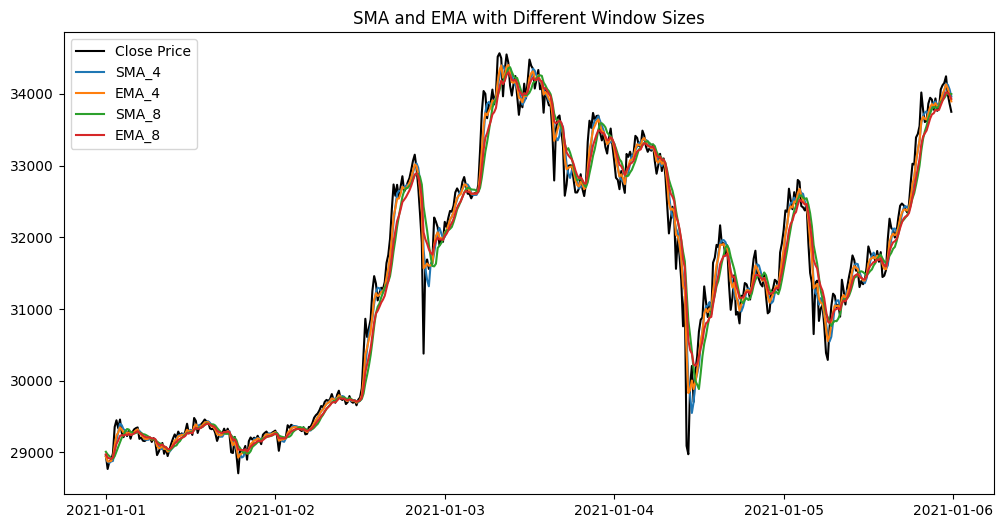

In [ ]:
import matplotlib.pyplot as plt

start_d, end_d = "2021-01-01", "2021-01-05"
# Visualize SMA and EMA for different window sizes
plt.figure(figsize=(12, 6))
plt.plot(df_btc_featured['close'][start_d:end_d], label='Close Price', color='black')

for window in [4, 8]:
    plt.plot(df_ma_test[f'SMA_{window}'][start_d:end_d], label=f'SMA_{window}')
    plt.plot(df_ma_test[f'EMA_{window}'][start_d:end_d], label=f'EMA_{window}')

plt.legend()
plt.title('SMA and EMA with Different Window Sizes')
plt.show()

Para tendencias inmediatas, una SMA de 8 y EMA de 4 son las que parecen captar mejor esas mismas. Usaremos esas.

In [ ]:
# Calcular SMA
def calculate_sma(df, window_size, objective_var):
    return df[objective_var].rolling(window=window_size).mean()

# Calcular EMA
def calculate_ema(df, window_size, objective_var):
    return df[objective_var].ewm(span=window_size, adjust=False).mean()

df_btc_feat_ma = df_btc_featured.copy()
df_btc_feat_ma["close_sma8"] = calculate_sma(df_btc_feat_ma, 8, objective_var = "close")
df_btc_feat_ma["close_ema4"] = calculate_ema(df_btc_feat_ma, 4, objective_var = "close")
df_btc_feat_ma = df_btc_feat_ma.dropna()
df_btc_feat_ma.head(6)

,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,close_sma8,close_ema4
date,,,,,,,,,,,
2017-08-18 02:00:00,4231.61,4269.36,4231.61,4251.95,0.691656,2937.584322,59.0,0.586354,2491.253697,4258.55000,4242.909013
2017-08-18 02:15:00,4251.95,4286.53,4234.00,4286.53,1.110702,4722.885300,67.0,0.897105,3814.998061,4255.73125,4260.357408
2017-08-18 02:30:00,4286.53,4298.64,4255.88,4278.05,1.506316,6441.671752,56.0,1.248401,5337.961555,4253.97375,4267.434445
2017-08-18 02:45:00,4278.05,4278.05,4242.75,4252.95,0.559393,2379.337432,57.0,0.520889,2215.189886,4250.27875,4261.640667
2017-08-18 03:00:00,4252.95,4267.59,4244.77,4244.77,0.451050,1917.635128,43.0,0.402966,1713.408468,4247.20500,4254.892400
2017-08-18 03:15:00,4267.59,4308.70,4244.77,4308.70,0.640010,2746.043065,89.0,0.486529,2088.156583,4258.69125,4276.415440


### 2.3 - Bandas de Bollinger


In [ ]:
def create_bollinger_bands(df_original, var_obj, window_size=20):

  #Crear una copia del df original
  df = df_original.copy()

  #Media movil de 20 (la tipica usada para las bandas de bollinger)
  df['SMA_20'] = df[var_obj].rolling(window=window_size).mean()

  # Desviacion estandar
  df['std_dev'] = df[var_obj].rolling(window=window_size).std()

  # Calcular las bandas superiores e inferiores
  df['bollinger_upper_band'] = df['SMA_20'] + (df['std_dev'] * 2)
  df['bollinger_lower_band'] = df['SMA_20'] - (df['std_dev'] * 2)

  #Eliminar las columnas auxiliares
  df = df.drop(columns = ["std_dev","SMA_20"])

  # Devolver el DF sin nulos
  return df.dropna()

df_btc_feat_boll = create_bollinger_bands(df_btc_feat_ma, var_obj = "close")
df_btc_feat_boll.head(6)

,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,close_sma8,close_ema4,bollinger_upper_band,bollinger_lower_band
date,,,,,,,,,,,,,
2017-08-18 06:45:00,4289.09,4289.09,4247.75,4247.75,1.386664,5929.254008,116.0,0.837944,3583.883617,4295.39875,4279.709554,4332.429251,4225.054749
2017-08-18 07:00:00,4289.09,4304.66,4254.92,4279.46,1.365287,5845.092693,82.0,1.027899,4403.393473,4294.34125,4279.609732,4332.303177,4227.931823
2017-08-18 07:15:00,4279.46,4304.66,4270.50,4286.08,0.933861,3997.857853,58.0,0.796699,3410.272899,4294.75125,4282.197839,4332.269423,4227.920577
2017-08-18 07:30:00,4286.08,4286.08,4270.48,4286.05,1.244537,5326.398928,48.0,1.132910,4848.724564,4289.15500,4283.738704,4332.726044,4228.263956
2017-08-18 07:45:00,4286.05,4304.67,4270.48,4304.67,0.969102,4153.197633,53.0,0.906348,3883.650934,4290.42625,4292.111222,4334.687497,4231.474503
2017-08-18 08:00:00,4304.67,4304.67,4285.00,4285.00,1.393085,5988.928196,44.0,1.392420,5986.074672,4286.85625,4289.266733,4333.445092,4236.739908


### 2.4 - Average True Rate

In [ ]:
def calculate_atr(df_original, window_size=14):

  df = df_original.copy()

  # Calcular el True Range (TR)
  df['high_low'] = df['high'] - df['low']
  df['high_prev_close'] = abs(df['high'] - df['close'].shift(1))
  df['low_prev_close'] = abs(df['low'] - df['close'].shift(1))

  df['TR'] = df[['high_low', 'high_prev_close', 'low_prev_close']].max(axis=1)

  # Calcular el ATR
  df['atr'] = df['TR'].ewm(span=window_size, adjust=False).mean()

  # Eliminar las columnas auxiliares
  df.drop(columns=['high_low', 'high_prev_close', 'low_prev_close', 'TR'], inplace=True)

  # Devolver el df
  return df

df_btc_feat_atr = calculate_atr(df_btc_feat_boll)
df_btc_feat_atr.head(6)

,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,close_sma8,close_ema4,bollinger_upper_band,bollinger_lower_band,atr
date,,,,,,,,,,,,,,
2017-08-18 06:45:00,4289.09,4289.09,4247.75,4247.75,1.386664,5929.254008,116.0,0.837944,3583.883617,4295.39875,4279.709554,4332.429251,4225.054749,41.340000
2017-08-18 07:00:00,4289.09,4304.66,4254.92,4279.46,1.365287,5845.092693,82.0,1.027899,4403.393473,4294.34125,4279.609732,4332.303177,4227.931823,43.416000
2017-08-18 07:15:00,4279.46,4304.66,4270.50,4286.08,0.933861,3997.857853,58.0,0.796699,3410.272899,4294.75125,4282.197839,4332.269423,4227.920577,42.181867
2017-08-18 07:30:00,4286.08,4286.08,4270.48,4286.05,1.244537,5326.398928,48.0,1.132910,4848.724564,4289.15500,4283.738704,4332.726044,4228.263956,38.637618
2017-08-18 07:45:00,4286.05,4304.67,4270.48,4304.67,0.969102,4153.197633,53.0,0.906348,3883.650934,4290.42625,4292.111222,4334.687497,4231.474503,38.044602
2017-08-18 08:00:00,4304.67,4304.67,4285.00,4285.00,1.393085,5988.928196,44.0,1.392420,5986.074672,4286.85625,4289.266733,4333.445092,4236.739908,35.594655


### 2.5 - Relative Strength Index

In [ ]:
def calculate_rsi(df_original, window=14):

  df = df_original.copy()

  # Calcular el cambio
  df['price_change'] = df['close'].diff()

  # Ganancias y perdidas
  df['gain'] = df['price_change'].apply(lambda x: x if x > 0 else 0)
  df['loss'] = df['price_change'].apply(lambda x: -x if x < 0 else 0)

  # Media de ganancias y perdidas
  df['avg_gain'] = df['gain'].rolling(window=window, min_periods=1).mean()
  df['avg_loss'] = df['loss'].rolling(window=window, min_periods=1).mean()

  # Relative Strength
  df['rs'] = df['avg_gain'] / df['avg_loss']

  # Calcular el RSI
  df['rsi'] = 100 - (100 / (1 + df['rs']))

  # Eliminar columnas auxiliares
  df.drop(columns=['price_change', 'gain', 'loss', 'avg_gain', 'avg_loss', 'rs'], inplace=True)

  # Devolver el DF
  return df.dropna()

df_btc_feat_rsi = calculate_rsi(df_btc_feat_atr)
df_btc_feat_rsi.head(6)

,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,close_sma8,close_ema4,bollinger_upper_band,bollinger_lower_band,atr,rsi
date,,,,,,,,,,,,,,,
2017-08-18 07:00:00,4289.09,4304.66,4254.92,4279.46,1.365287,5845.092693,82.0,1.027899,4403.393473,4294.34125,4279.609732,4332.303177,4227.931823,43.416000,100.000000
2017-08-18 07:15:00,4279.46,4304.66,4270.50,4286.08,0.933861,3997.857853,58.0,0.796699,3410.272899,4294.75125,4282.197839,4332.269423,4227.920577,42.181867,100.000000
2017-08-18 07:30:00,4286.08,4286.08,4270.48,4286.05,1.244537,5326.398928,48.0,1.132910,4848.724564,4289.15500,4283.738704,4332.726044,4228.263956,38.637618,99.921794
2017-08-18 07:45:00,4286.05,4304.67,4270.48,4304.67,0.969102,4153.197633,53.0,0.906348,3883.650934,4290.42625,4292.111222,4334.687497,4231.474503,38.044602,99.947350
2017-08-18 08:00:00,4304.67,4304.67,4285.00,4285.00,1.393085,5988.928196,44.0,1.392420,5986.074672,4286.85625,4289.266733,4333.445092,4236.739908,35.594655,74.298761
2017-08-18 08:15:00,4285.00,4300.25,4284.96,4300.25,1.276935,5485.061010,51.0,1.215913,5223.069909,4284.79375,4293.660040,4332.296260,4237.043740,32.887368,78.563656


Ahora, guardar el DataFrame procesado y con las nuevas features creadas

In [ ]:
df_btc_feat_rsi.to_csv('btc_2017_to_2023_featured_new_variables.csv', index=True)

### 2.6 - Importar los DataFrames previamente creados

DataFrame con las columnas originales agregadas como se indicó

In [ ]:
import pandas as pd
df_btc_featured = pd.read_csv('btc_2017_to_2023_featured.csv', index_col='date', parse_dates=True)

Dataframe completo con las nuevas features creadas

In [ ]:
import pandas as pd
df_btc_featured_new_var = pd.read_csv('btc_2017_to_2023_featured_new_variables.csv', index_col='date', parse_dates=True)

## 3 - Creación y Entrenamiento de Redes Neuronales LSTM

### 3.1 - Dataset, formateo y preparación de los datos

Clase dataset serie temporal

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np

class TimeSeriesDataset(Dataset):
    def __init__(self, df, target_column, window_size, offset, horizon):
        self.data = df.values
        self.target_column = df.columns.get_loc(target_column)
        self.window_size = window_size
        self.offset = offset
        self.horizon = horizon

    def __len__(self):
        return len(self.data) - self.window_size - self.offset - self.horizon + 1

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.window_size]
        y = self.data[idx + self.window_size + self.offset:idx + self.window_size + self.offset + self.horizon, self.target_column]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

#Objeto que encapsula los parametros para la creación de las features en ventanas predictoras y número de time steps a predecir
class TimeSeriesDatasetParameters():
  def __init__(self, target_column, window_size, offset, horizon):
    self.target_column = target_column
    self.window_size = window_size
    self.offset = offset
    self.horizon = horizon

Función para preparar los datos. Lo único que cambia dependiendo de si es stateful o no es el parámetro shuffle. Por que? Porque si queremos que sea stateful, debemos preservar el orden entre las batchs. En una LSTM stateless esto no es necesario y pueden mezclarse.

In [ ]:
def prepare_dataloader(df, target_column, window_size, offset, horizon, batch_size, is_stateful):
    dataset = TimeSeriesDataset(df, target_column, window_size, offset, horizon)
    shuffle = not is_stateful
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=is_stateful)
    return dataloader

### 3.2 - Redes LSTM

Stateless

In [ ]:
import torch.nn as nn

class StatelessLSTMModel(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.5):
        super(StatelessLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)

        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):

        # Inicializar los hidden y cell satates a 0 (y asegurarse que estan en el mismo device que las inputs)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # forward pass
        out, (hn, cn) = self.lstm(x, (h0, c0))

        '''
          out contiene todos los hidden states para cada momento temporal para el ULTIMO layer
          hn continete los hidden states para el ULTIMO momento temporal para CADA layer
          cn contiene los cell states para el ULTIMO momento temporar para CADA layer
        '''

        # Para el fully-connected layer usamos solo el tensor correspondiente al ULTIMO momento temporal del ultimo layer.
        # Esto lo hacemos debido a que se supone que este tensor contendrá información recogida de toda la secuencia
        out = self.fc(out[:, -1, :])

        return out

Stateful

In [ ]:
class StatefulLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, batch_size, dropout=0.5):
        super(StatefulLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_size = batch_size

        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)

        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)

        # Inicializar hidden y cell states
        self.hn = torch.zeros(self.num_layers, self.batch_size, self.hidden_size)
        self.cn = torch.zeros(self.num_layers, self.batch_size, self.hidden_size)

    def forward(self, x):

        # Asegurarse que los hidden y cell states estan en el mismo device que las inputs
        self.hn = self.hn.to(x.device).detach()
        self.cn = self.cn.to(x.device).detach()

        # Perform LSTM forward pass with the current hidden and cell states
        # Hacer un forward pass usando los actuales hn y cn (por eso es stateful)
        out, (hn, cn) = self.lstm(x, (self.hn, self.cn))

        self.hn = hn.detach()
        self.cn = cn.detach()

        # Como hicimos en la stateless, pasamos solo el tensor del último instante temporal
        out = self.fc(out[:, -1, :])

        return out

    def reset_states(self):
        # Resetear los hidden y cell states. Esto se usará al principio de cada epoch para evitar que
        # una epoch se vea afectada por los estados de la epoch anterior
        self.hn = torch.zeros(self.num_layers, self.batch_size, self.hidden_size).to(self.hn.device)
        self.cn = torch.zeros(self.num_layers, self.batch_size, self.hidden_size).to(self.cn.device)

### 3.3 - Entrenamiento del modelo

Crearemos una función que, entrene el modelo, dividiendo los datos en train y test para ir viendo al final de cada epoch como va desempeñando el modelo.

In [ ]:
import torch.optim as optim
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

def train_lstm_model(data, input_size, hidden_size, num_layers, output_size, batch_size,
                     num_epochs, learning_rate, is_stateful, ts_dataset_parameters, val_size = 0.1, criterion = nn.MSELoss()):

    # Dividir los datos en train y test
    train_df, val_df = train_test_split(data, test_size=val_size, shuffle=False)

    # Preparar los data loaders
    train_loader = prepare_dataloader(train_df, ts_dataset_parameters.target_column,
                                      ts_dataset_parameters.window_size, ts_dataset_parameters.offset,
                                      ts_dataset_parameters.horizon, batch_size, is_stateful)
    val_loader = prepare_dataloader(val_df, ts_dataset_parameters.target_column,
                                    ts_dataset_parameters.window_size, ts_dataset_parameters.offset,
                                    ts_dataset_parameters.horizon, batch_size, is_stateful)

    # Seleccionar el modelo a usar, stateless o stateful
    if is_stateful:
        model = StatefulLSTMModel(input_size, hidden_size, num_layers, output_size, batch_size)
    else:
        model = StatelessLSTMModel(input_size, hidden_size, num_layers, output_size)

    # Mover el modelo al device apropiado
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Crear una barra de progreso
    num_training_steps = num_epochs * len(train_loader)
    progress_bar = tqdm(range(num_training_steps))

    # Bucle de training
    for epoch in range(num_epochs):

        # Modelo en modo train
        model.train()

        # SI es stateful, hay que resetear los estados al final de cada epoch (como está explicado en la clase del modelo)
        if is_stateful:
            model.reset_states()

        # Iterar en todas las batches del dataset de train
        for inputs, targets in train_loader:

            # Inputs y targets al device
            inputs, targets = inputs.to(device), targets.to(device)

            # Si no es stateful, hay que inicializar los hn y cn a 0
            if not is_stateful:
                # Initialize hidden and cell states for each batch for stateless LSTM
                h0 = torch.zeros(num_layers, inputs.size(0), hidden_size).to(device)
                c0 = torch.zeros(num_layers, inputs.size(0), hidden_size).to(device)
                outputs, _ = model(inputs, h0, c0)
            else:
                outputs = model(inputs)

            # Calcular la perdida
            loss = criterion(outputs, targets.view(outputs.size()))

            # Resetear los gradientes del previo forward pass
            optimizer.zero_grad()

            # Calcular los gradientes de la perdida con respecto a los parametros del modelo
            loss.backward(retain_graph=True)

            # Actualizar los parametros del modelo (dar un "paso" en la direccion del gradiente)
            optimizer.step()

            # Actualizar la barra de progreso
            progress_bar.update(1)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

        # Despues de cada epoch, bucle de validacion
        model.eval()  # Modo evaluacion
        val_loss = 0

        #No pediremos que guarde los gradientes, para agilizar el proceso, ya que en la evaluacion no son necesarios
        # El proceso es el mismo que en el bucle de train pero sin calcular los gradientes ni actualizar los pesos del modelo
        with torch.no_grad():
            if is_stateful:
                model.reset_states()

            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)

                if not is_stateful:

                    h0 = torch.zeros(num_layers, inputs.size(0), hidden_size).to(device)
                    c0 = torch.zeros(num_layers, inputs.size(0), hidden_size).to(device)
                    outputs, _ = model(inputs, h0, c0)
                else:
                    outputs = model(inputs)

                loss = criterion(outputs, targets.view(outputs.size()))
                val_loss += loss.item()

        val_loss /= len(val_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}')

    print("Training completed!")

    # Devolver el modelo
    return model

Ahora, lo último que queda antes de entrenar el modelo, es estandarizar las features, ya que las redes neuronales funcionan mucho mejor asi.

**IMPORTANTE**: Cuando se quiera usar el modelo, habrá que escalar las nuevas features CON EL MISMO scaler que estamos usando para entrenar.

In [ ]:
from sklearn.preprocessing import StandardScaler

# ScalerEscaler
scaler = StandardScaler()

# Escalar el df
df_btc_scaled = pd.DataFrame(scaler.fit_transform(df_btc_featured_new_var), columns = df_btc_featured_new_var.columns, index = df_btc_featured_new_var.index)

# Separar en train y test para probar el modelo una vez entrenemos
df_tr, df_test = train_test_split(df_btc_scaled, test_size=0.1, shuffle=False)

In [ ]:
# Time series dataset parametros
time_series_dataset_parameters = TimeSeriesDatasetParameters(
    target_column = "close",
    window_size = 480,
    offset = 0,
    horizon = 1
)

# Parámetros del modelo
input_size = df_tr.shape[1]
hidden_size = 8
num_layers = 2
output_size = time_series_dataset_parameters.horizon
batch_size = 64
num_epochs = 100
learning_rate = 0.001
is_stateful = True

# Entrenar el modelo
model = train_lstm_model(
    data=df_tr,
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    output_size=output_size,
    batch_size=batch_size,
    num_epochs=num_epochs,
    learning_rate=learning_rate,
    is_stateful=is_stateful,
    ts_dataset_parameters=time_series_dataset_parameters
)

  0%|          | 0/263300 [00:00<?, ?it/s]

Epoch [1/100], Loss: 0.1639
Epoch [1/100], Validation Loss: 0.5748
Epoch [2/100], Loss: 0.2317
Epoch [2/100], Validation Loss: 0.7224
Epoch [3/100], Loss: 0.0554
Epoch [3/100], Validation Loss: 0.3964
Epoch [4/100], Loss: 0.0944
Epoch [4/100], Validation Loss: 0.3819
Epoch [5/100], Loss: 0.0930
Epoch [5/100], Validation Loss: 0.0821
Epoch [6/100], Loss: 0.0896
Epoch [6/100], Validation Loss: 0.0794
Epoch [7/100], Loss: 0.0847
Epoch [7/100], Validation Loss: 0.1391
Epoch [8/100], Loss: 0.0869
Epoch [8/100], Validation Loss: 0.1316
Epoch [9/100], Loss: 0.0960
Epoch [9/100], Validation Loss: 0.1392
Epoch [10/100], Loss: 0.0650
Epoch [10/100], Validation Loss: 0.1543
Epoch [11/100], Loss: 0.0690
Epoch [11/100], Validation Loss: 0.2859
Epoch [12/100], Loss: 0.0700
Epoch [12/100], Validation Loss: 0.1694
Epoch [13/100], Loss: 0.0705
Epoch [13/100], Validation Loss: 0.1738
Epoch [14/100], Loss: 0.0787
Epoch [14/100], Validation Loss: 0.2121
Epoch [15/100], Loss: 0.0635
Epoch [15/100], Validat

Guardamos el modelo y sus parámetros

In [ ]:
model_params = {
    "input_size": input_size,
    "hidden_size": hidden_size,
    "num_layers": num_layers,
    "output_size": output_size,
    "batch_size": batch_size,
    "dropout": 0.5,
}

# Save the model state dictionary along with the parameters
torch.save({
    "model_state_dict": model.state_dict(),
    "model_params": model_params
}, 'stateful_lstm_model2_100_epochs.pth')

Cargar el modelo

In [ ]:
# Load the saved state dictionary and parameters
checkpoint = torch.load('stateful_lstm_model2_100_epochs.pth')

# Extract the model parameters
model_params = checkpoint["model_params"]

# Create a new instance of the model with the loaded parameters
model = StatefulLSTMModel(
    input_size=model_params["input_size"],
    hidden_size=model_params["hidden_size"],
    num_layers=model_params["num_layers"],
    output_size=model_params["output_size"],
    batch_size=model_params["batch_size"]
)

# Load the saved state dictionary into the model
model.load_state_dict(checkpoint["model_state_dict"])

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

StatefulLSTMModel(
  (lstm): LSTM(15, 128, num_layers=8, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

## 4 - Testear el modelo

Para testear el modelo, preparamos un dataloader con el dataframe que dejamos para test

In [ ]:
test_loader = prepare_dataloader(df=df_test,
                                 target_column="close",
                                 window_size=480,
                                 offset=0,
                                 horizon=1,
                                 batch_size=64, #Misma batch_size con la que entrenamos el modelo.
                                 is_stateful=True)

En este caso, usamos la misma batch size con la que entrenamos el modelo para no tener que hacer modificaciones. Si quisieramos hacer predicciones de 1 en 1, se podría hacer inicializando los hn y cn del modelo para que tengan la dimension "batch_size" igual a 1.

In [ ]:
# Dataframe donde guardaremos los resultados de las predicciones y los valores reales
df_results = pd.DataFrame(columns=["pred","real"])

#Modelo en modo evaluacion
model.eval()

#Cogemos el device por si no lo teniamos
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Iteramos a través del dataloader
for inputs, targets in test_loader:

  #Inputs al device
  inputs = inputs.to(device)

  #Reseteamos los hn y cn del modelo
  model.reset_states()

  #Hacemos las predicciones
  with torch.no_grad():
    predictions = model(inputs)

  #Las pasamos a la cpu y eliminamos la dimension del batch size
  predictions = predictions.cpu().numpy().squeeze()

  # Añadimos las nuevas filas al dataframe
  d_rows = {
      "pred": predictions.tolist(),
      "real": targets.squeeze().tolist()
  }
  new_rows = pd.DataFrame(d_rows)

  df_results = pd.concat([df_results, new_rows])

#Enseñamos el DF
df_results = df_results.reset_index(drop=True)
df_results

,pred,real
0,0.019256,-0.216839
1,2.758427,-0.215813
2,2.766768,-0.216301
3,2.770669,-0.216806
4,0.019570,-0.216751
...,...,...
20347,0.616542,0.581916
20348,0.610321,0.576496
20349,0.599382,0.577522
20350,0.603665,0.576678


Vamos a ver su MSE

In [ ]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_true=df_results["real"], y_pred=df_results["pred"])

0.04549581187623116

Y por ultimo, graficamos el resultado

<Axes: >

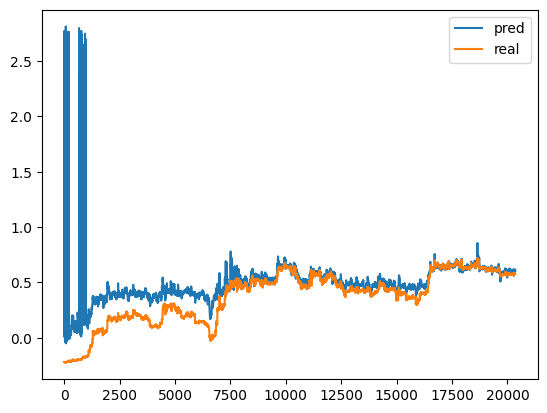

In [ ]:
df_results.plot()

Vemos que, parece que hay un gran error al principio en las predicciones (puede ser porque esté cogiendo patrones pasados, habira que hacer más pruebas o incluso ver si una Stateless LSTM funcionaría mejor).

Aún así, estas predicciones son para los datos ESCALADOS. Habría que revertir la transformación para ver los valores reales de las predicciones.

## 5 - Unión de los datos usados con los obtenidos de GDELT

Vamos ahora a entrenar otro modelo esta vez usando también los datos de GDELT. Cargamos el DataFrame obtenido de GDELT

In [ ]:
import pandas as pd

#Fechas de inicio y fin del dataframe del bitcoin, seleccionar solo esas fechas
end_date = df_btc_featured_new_var.index.max().strftime("%Y-%m-%d %H:%M")
start_date = df_btc_featured_new_var.index.min().strftime("%Y-%m-%d %H:%M")

df_news = pd.read_csv("bitcoin_news_2017_to_2023.csv", index_col='Unnamed: 0', parse_dates=['Unnamed: 0'])
df_news.index = pd.to_datetime(df_news.index)

df_reset = df_news.reset_index()
df_reset = df_reset.drop_duplicates(subset='index')
df_news = df_reset.set_index('index')
df_news.index = pd.to_datetime(df_news.index)
df_news.index.name = "date"
df_news = df_news.tz_localize(None)
df_news = df_news[start_date:end_date]
df_news

,article_count,atricle_perc,avg_tone,all_articles
date,,,,
2017-08-18 07:00:00,7,0.001014,0.0215,6903.0
2017-08-18 07:15:00,0,0.000000,0.0000,0.0
2017-08-18 07:30:00,7,0.000889,-0.8131,7870.0
2017-08-18 07:45:00,13,0.001738,-1.4109,7478.0
2017-08-18 08:00:00,10,0.001203,-0.5666,8313.0
...,...,...,...,...
2023-07-31 22:45:00,0,0.000000,0.0000,0.0
2023-07-31 23:00:00,0,0.000000,0.0000,510.0
2023-07-31 23:15:00,0,0.000000,0.0000,0.0


Vemos si las longitudes encajan

In [ ]:
print(f"Length df_btc_featured_new_var: {len(df_btc_featured_new_var)}")
print(f"Length df_news: {len(df_news)}")

Length df_btc_featured_new_var: 208676
Length df_news: 208676


Y juntamos ambos DataFranes en uno

In [ ]:
df_merged = pd.merge(left = df_btc_featured_new_var, right = df_news, left_index=True, right_index=True)
df_merged

,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,close_sma8,close_ema4,bollinger_upper_band,bollinger_lower_band,atr,rsi,article_count,atricle_perc,avg_tone,all_articles
date,,,,,,,,,,,,,,,,,,,
2017-08-18 07:00:00,4289.09,4304.66,4254.92,4279.46,1.365287,5845.092693,82.0,1.027899,4403.393473,4294.34125,4279.609732,4332.303177,4227.931823,43.416000,100.000000,7,0.001014,0.0215,6903.0
2017-08-18 07:15:00,4279.46,4304.66,4270.50,4286.08,0.933861,3997.857853,58.0,0.796699,3410.272899,4294.75125,4282.197839,4332.269423,4227.920577,42.181867,100.000000,0,0.000000,0.0000,0.0
2017-08-18 07:30:00,4286.08,4286.08,4270.48,4286.05,1.244537,5326.398928,48.0,1.132910,4848.724564,4289.15500,4283.738704,4332.726044,4228.263956,38.637618,99.921794,7,0.000889,-0.8131,7870.0
2017-08-18 07:45:00,4286.05,4304.67,4270.48,4304.67,0.969102,4153.197633,53.0,0.906348,3883.650934,4290.42625,4292.111222,4334.687497,4231.474503,38.044602,99.947350,13,0.001738,-1.4109,7478.0
2017-08-18 08:00:00,4304.67,4304.67,4285.00,4285.00,1.393085,5988.928196,44.0,1.392420,5986.074672,4286.85625,4289.266733,4333.445092,4236.739908,35.594655,74.298761,10,0.001203,-0.5666,8313.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-31 22:45:00,29236.62,29236.62,29205.08,29206.89,3.386559,98939.930005,2971.0,1.224165,35762.151279,29214.64625,29217.618458,29247.238580,29166.647420,50.807772,51.634933,0,0.000000,0.0000,0.0
2023-07-31 23:00:00,29206.88,29210.00,29201.00,29209.56,5.506339,160818.632671,3443.0,3.942473,115141.377296,29215.63875,29214.395075,29247.288946,29166.679054,45.233403,47.746784,0,0.000000,0.0000,510.0
2023-07-31 23:15:00,29209.56,29209.57,29190.00,29205.53,6.595953,192587.953492,3239.0,3.828686,111782.779701,29215.17000,29210.849045,29247.267960,29166.652040,41.811616,47.481112,0,0.000000,0.0000,0.0


## 6 - Entrenamiento de un modelo con los nuevos datos

Re-definimos el modelo y función de entrenamiento

In [ ]:
class StatefulLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, batch_size, dropout=0.5):
        super(StatefulLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_size = batch_size

        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)

        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)

        # Inicializar hidden y cell states
        self.hn = torch.zeros(self.num_layers, self.batch_size, self.hidden_size)
        self.cn = torch.zeros(self.num_layers, self.batch_size, self.hidden_size)

    def forward(self, x):

        # Asegurarse que los hidden y cell states estan en el mismo device que las inputs
        self.hn = self.hn.to(x.device).detach()
        self.cn = self.cn.to(x.device).detach()

        # Perform LSTM forward pass with the current hidden and cell states
        # Hacer un forward pass usando los actuales hn y cn (por eso es stateful)
        out, (hn, cn) = self.lstm(x, (self.hn, self.cn))

        self.hn = hn.detach()
        self.cn = cn.detach()

        # Como hicimos en la stateless, pasamos solo el tensor del último instante temporal
        out = self.fc(out[:, -1, :])

        return out

    def reset_states(self):
        # Resetear los hidden y cell states. Esto se usará al principio de cada epoch para evitar que
        # una epoch se vea afectada por los estados de la epoch anterior
        self.hn = torch.zeros(self.num_layers, self.batch_size, self.hidden_size).to(self.hn.device)
        self.cn = torch.zeros(self.num_layers, self.batch_size, self.hidden_size).to(self.cn.device)

Definimos esta vez una función de early stopping

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0, path='checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

Redefinimos la función de entrenamiento añadiendo:

- Regurlaricación l2 (`weight_decay`)
- Early stopping

In [ ]:
import torch.optim as optim
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

def train_lstm_model(data, input_size, hidden_size, num_layers, output_size, batch_size,
                     num_epochs, learning_rate, is_stateful, ts_dataset_parameters, dropout=0.5,
                     patience=7, weight_decay=1e-5, val_size = 0.1, criterion = nn.MSELoss()):

    # Dividir los datos en train y test
    train_df, val_df = train_test_split(data, test_size=val_size, shuffle=False)

    # Preparar los data loaders
    train_loader = prepare_dataloader(train_df, ts_dataset_parameters.target_column,
                                      ts_dataset_parameters.window_size, ts_dataset_parameters.offset,
                                      ts_dataset_parameters.horizon, batch_size, is_stateful)
    val_loader = prepare_dataloader(val_df, ts_dataset_parameters.target_column,
                                    ts_dataset_parameters.window_size, ts_dataset_parameters.offset,
                                    ts_dataset_parameters.horizon, batch_size, is_stateful)

    # Seleccionar el modelo a usar, stateless o stateful
    if is_stateful:
        model = StatefulLSTMModel(input_size, hidden_size, num_layers, output_size, batch_size)
    else:
        model = StatelessLSTMModel(input_size, hidden_size, num_layers, output_size)

    # Mover el modelo al device apropiado
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay) #Regularización l2

    # Crear una barra de progreso
    num_training_steps = num_epochs * len(train_loader)
    progress_bar = tqdm(range(num_training_steps))

    #Crear un early stopping
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    # Bucle de training
    for epoch in range(num_epochs):

        # Modelo en modo train
        model.train()

        # SI es stateful, hay que resetear los estados al final de cada epoch (como está explicado en la clase del modelo)
        if is_stateful:
            model.reset_states()

        # Iterar en todas las batches del dataset de train
        for inputs, targets in train_loader:

            # Inputs y targets al device
            inputs, targets = inputs.to(device), targets.to(device)

            # Si no es stateful, hay que inicializar los hn y cn a 0
            if not is_stateful:
                # Initialize hidden and cell states for each batch for stateless LSTM
                h0 = torch.zeros(num_layers, inputs.size(0), hidden_size).to(device)
                c0 = torch.zeros(num_layers, inputs.size(0), hidden_size).to(device)
                outputs, _ = model(inputs, h0, c0)
            else:
                outputs = model(inputs)

            # Calcular la perdida
            loss = criterion(outputs, targets.view(outputs.size()))

            # Resetear los gradientes del previo forward pass
            optimizer.zero_grad()

            # Calcular los gradientes de la perdida con respecto a los parametros del modelo
            loss.backward(retain_graph=True)

            # Actualizar los parametros del modelo (dar un "paso" en la direccion del gradiente)
            optimizer.step()

            # Actualizar la barra de progreso
            progress_bar.update(1)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

        # Despues de cada epoch, bucle de validacion
        model.eval()  # Modo evaluacion
        val_loss = 0

        #No pediremos que guarde los gradientes, para agilizar el proceso, ya que en la evaluacion no son necesarios
        # El proceso es el mismo que en el bucle de train pero sin calcular los gradientes ni actualizar los pesos del modelo
        with torch.no_grad():
            if is_stateful:
                model.reset_states()

            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)

                if not is_stateful:

                    h0 = torch.zeros(num_layers, inputs.size(0), hidden_size).to(device)
                    c0 = torch.zeros(num_layers, inputs.size(0), hidden_size).to(device)
                    outputs, _ = model(inputs, h0, c0)
                else:
                    outputs = model(inputs)

                loss = criterion(outputs, targets.view(outputs.size()))
                val_loss += loss.item()

        val_loss /= len(val_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}')

        #Llamamos al early stopping por si hay que parar el entrenamiento aqui y recuperar la mejor epoch
        early_stopping(val_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break

    print("Training completed!")

    #Cargamos los mejores pesos del modelo (mejor epoch)
    model.load_state_dict(torch.load('checkpoint.pt'))

    # Devolver el modelo
    return model

Volvemos a entrenar otro modelo LSTM, para ver si mejora con respecto al anterior

In [ ]:
#Escalar las variables de nuevo
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd

# ScalerEscaler
scaler = StandardScaler()

# Escalar el df
df_btc_scaled = pd.DataFrame(scaler.fit_transform(df_merged), columns = df_merged.columns, index = df_merged.index)

# Separar en train y test para probar el modelo una vez entrenemos
df_tr, df_test = train_test_split(df_btc_scaled, test_size=0.1, shuffle=False)

Entrenar el modelo

In [ ]:
# Time series dataset parametros
time_series_dataset_parameters = TimeSeriesDatasetParameters(
    target_column = "close",
    window_size = 480,
    offset = 0,
    horizon = 1
)

# Parámetros del modelo
input_size = df_tr.shape[1]
hidden_size = 4
num_layers = 2
output_size = time_series_dataset_parameters.horizon
batch_size = 128
num_epochs = 100
learning_rate = 0.001
is_stateful = True
dropout = 0.5
weight_decay = 1e-5
patience=7

# Entrenar el modelo
model = train_lstm_model(
    data=df_tr,
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    output_size=output_size,
    batch_size=batch_size,
    num_epochs=num_epochs,
    learning_rate=learning_rate,
    dropout=dropout,
    patience=patience,
    weight_decay=weight_decay,
    is_stateful=is_stateful,
    ts_dataset_parameters=time_series_dataset_parameters
)

  0%|          | 0/131600 [00:00<?, ?it/s]

Epoch [1/100], Loss: 0.0612
Epoch [1/100], Validation Loss: 0.3634
Validation loss decreased (inf --> 0.363407).  Saving model ...
Epoch [2/100], Loss: 0.0712
Epoch [2/100], Validation Loss: 0.3471
Validation loss decreased (0.363407 --> 0.347078).  Saving model ...
Epoch [3/100], Loss: 0.1908
Epoch [3/100], Validation Loss: 0.7277
EarlyStopping counter: 1 out of 7
Epoch [4/100], Loss: 0.1471
Epoch [4/100], Validation Loss: 0.5867
EarlyStopping counter: 2 out of 7
Epoch [5/100], Loss: 0.0950
Epoch [5/100], Validation Loss: 0.4676
EarlyStopping counter: 3 out of 7
Epoch [6/100], Loss: 0.0616
Epoch [6/100], Validation Loss: 0.4683
EarlyStopping counter: 4 out of 7
Epoch [7/100], Loss: 0.0425
Epoch [7/100], Validation Loss: 0.4274
EarlyStopping counter: 5 out of 7
Epoch [8/100], Loss: 0.0214
Epoch [8/100], Validation Loss: 0.3723
EarlyStopping counter: 6 out of 7
Epoch [9/100], Loss: 0.0122
Epoch [9/100], Validation Loss: 0.3356
Validation loss decreased (0.347078 --> 0.335646).  Saving m

Guardamos el modelo

In [ ]:
def guardar_modelo(model_params, model_name):

  # Save the model state dictionary along with the parameters
  torch.save({
      "model_state_dict": model.state_dict(),
      "model_params": model_params
  }, model_name)

def cargar_modelo(model_name):

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  # Load the saved state dictionary and parameters
  checkpoint = torch.load(model_name, map_location=torch.device('cpu'))

  # Extract the model parameters
  model_params = checkpoint["model_params"]

  # Create a new instance of the model with the loaded parameters
  model = StatefulLSTMModel(
      input_size=model_params["input_size"],
      hidden_size=model_params["hidden_size"],
      num_layers=model_params["num_layers"],
      output_size=model_params["output_size"],
      batch_size=model_params["batch_size"]
  )

  # Load the saved state dictionary into the model
  model.load_state_dict(checkpoint["model_state_dict"])

  # Move the model to the appropriate device
  model.to(device)

  return model

In [ ]:
model_params = {
    "input_size": input_size,
    "hidden_size": hidden_size,
    "num_layers": num_layers,
    "output_size": output_size,
    "batch_size": batch_size,
    "dropout": dropout,
}

guardar_modelo(model_params, "stateful_lstm_model_merged__44_epochs.pth")

Cargar el modelo

In [ ]:
cargar_modelo("stateful_lstm_model_merged__44_epochs.pth")

## 7 - Testeo del segundo modelo

In [ ]:
test_loader = prepare_dataloader(df=df_test,
                                 target_column="close",
                                 window_size=480,
                                 offset=0,
                                 horizon=1,
                                 batch_size=128, #Misma batch_size con la que entrenamos el modelo.
                                 is_stateful=True)

In [ ]:
import math

def make_predictions(model, test_loader, batch_size, window_size):
  # Dataframe donde guardaremos los resultados de las predicciones y los valores reales
  df_results = pd.DataFrame(columns=["pred","real"])

  #Modelo en modo evaluacion
  model.eval()

  #Cogemos el device por si no lo teniamos
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  #Iteramos a través del dataloader
  for inputs, targets in test_loader:

    #Inputs al device
    inputs = inputs.to(device)

    #Reseteamos los hn y cn del modelo
    model.reset_states()

    #Hacemos las predicciones
    with torch.no_grad():
      predictions = model(inputs)

    #Las pasamos a la cpu y eliminamos la dimension del batch size
    predictions = predictions.cpu().numpy().squeeze()

    # Añadimos las nuevas filas al dataframe
    d_rows = {
        "pred": predictions.tolist(),
        "real": targets.squeeze().tolist()
    }
    new_rows = pd.DataFrame(d_rows)

    df_results = pd.concat([df_results, new_rows])

  #Devolvemos
  df_results.index = df_test[window_size:window_size + math.floor(df_test[window_size:].shape[0]/batch_size) * batch_size].index

  return df_results

Vemos el MSE

In [ ]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_true=df_results["real"], y_pred=df_results["pred"])

0.007015739042431702

<Axes: xlabel='date'>

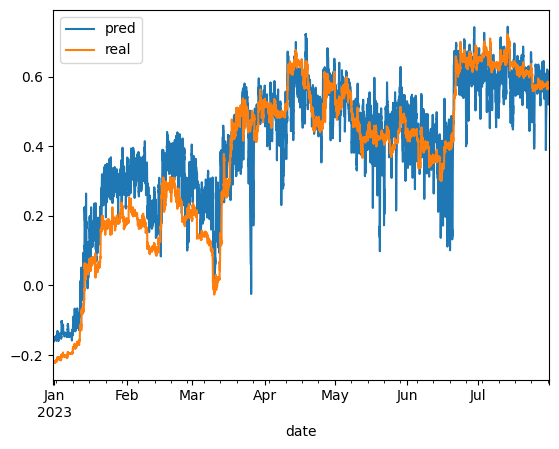

In [ ]:
df_results.plot()

Hacemos la transformación inversa

In [ ]:
def get_inverse_target(scaler, var_obj, column_names, values):

  #Creamos un dataframe con todas las columnas y el índice de la serie
  df_to_inverse = pd.DataFrame(index=values.index, columns=column_names)
  #Asignamos los valores a la columna que vamos a transformar
  df_to_inverse[var_obj] = values

  #Ponemos el resto de valores a 0
  for column in [col for col in df_to_inverse.columns if col != var_obj]:
    df_to_inverse[column] = 0

  #Transformamos de vuelta y devolvemos la columna objetivo
  return pd.DataFrame(scaler.inverse_transform(df_to_inverse),columns = df_to_inverse.columns, index=df_to_inverse.index)[var_obj]

In [ ]:
real_unscaled_values = get_inverse_target(
    scaler=scaler,
    var_obj="close",
    column_names=df_test.columns,
    values= df_results["real"]
)

pred_unescaled_values = get_inverse_target(
    scaler=scaler,
    var_obj="close",
    column_names=df_test.columns,
    values= df_results["pred"]
)

df_results_unscaled = pd.concat([real_unscaled_values.rename("real"), pred_unescaled_values.rename("pred")], axis=1)
df_results_unscaled

,real,pred
date,,
2022-12-31 15:00:00,16594.400085,17660.900832
2022-12-31 15:15:00,16610.879938,17622.184615
2022-12-31 15:30:00,16603.040115,17618.652602
2022-12-31 15:45:00,16594.920075,17658.213057
2022-12-31 16:00:00,16595.810018,17658.186255
...,...,...
2023-07-31 13:45:00,29421.520397,29114.776119
2023-07-31 14:00:00,29334.479740,29244.997304
2023-07-31 14:15:00,29350.959593,29274.695882


Y mostramos los resultados

<Axes: xlabel='date'>

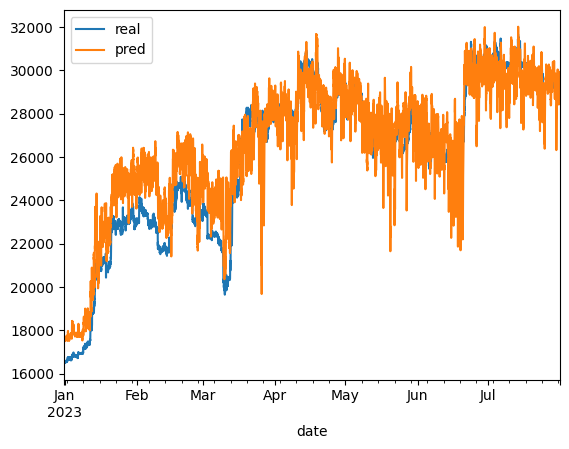

In [ ]:
df_results_unscaled.plot()

Y vemos su MSE y su MAE

In [ ]:
from sklearn.metrics import mean_absolute_error

mse = mean_squared_error(y_true=df_results_unscaled.real, y_pred=df_results_unscaled.pred)
mae = mean_absolute_error(y_true=df_results_unscaled.real, y_pred=df_results_unscaled.pred)

print(f"MSE -> {mse}")
print(f"MAE -> {mae}")

MSE -> 1809276.5354872157
MAE -> 1077.8299078163207


### 7.2 - Tunear parámetros del modelo

In [ ]:
# Time series dataset parametros
time_series_dataset_parameters = TimeSeriesDatasetParameters(
    target_column = "close",
    window_size = 960,
    offset = 0,
    horizon = 1
)

# Parámetros del modelo
input_size = df_tr.shape[1]
hidden_size = 4
num_layers = 1
output_size = time_series_dataset_parameters.horizon
batch_size = 128
num_epochs = 100
learning_rate = 0.0015
is_stateful = True
dropout = 0.4
weight_decay = 1e-5
patience=8

# Entrenar el modelo
model = train_lstm_model(
    data=df_tr,
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    output_size=output_size,
    batch_size=batch_size,
    num_epochs=num_epochs,
    learning_rate=learning_rate,
    dropout=dropout,
    patience=patience,
    weight_decay=weight_decay,
    is_stateful=is_stateful,
    ts_dataset_parameters=time_series_dataset_parameters
)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  0%|          | 0/131300 [00:00<?, ?it/s]

Epoch [1/100], Loss: 0.0923
Epoch [1/100], Validation Loss: 0.2888
Validation loss decreased (inf --> 0.288847).  Saving model ...
Epoch [2/100], Loss: 0.0315
Epoch [2/100], Validation Loss: 0.0667
Validation loss decreased (0.288847 --> 0.066708).  Saving model ...
Epoch [3/100], Loss: 0.0227
Epoch [3/100], Validation Loss: 0.0595
Validation loss decreased (0.066708 --> 0.059542).  Saving model ...
Epoch [4/100], Loss: 0.0061
Epoch [4/100], Validation Loss: 0.0527
Validation loss decreased (0.059542 --> 0.052722).  Saving model ...
Epoch [5/100], Loss: 0.0064
Epoch [5/100], Validation Loss: 0.0364
Validation loss decreased (0.052722 --> 0.036411).  Saving model ...
Epoch [6/100], Loss: 0.0057
Epoch [6/100], Validation Loss: 0.0243
Validation loss decreased (0.036411 --> 0.024311).  Saving model ...
Epoch [7/100], Loss: 0.0041
Epoch [7/100], Validation Loss: 0.0166
Validation loss decreased (0.024311 --> 0.016586).  Saving model ...
Epoch [8/100], Loss: 0.0040
Epoch [8/100], Validation

Guardar el modelo

In [ ]:
model_params = {
    "input_size": input_size,
    "hidden_size": hidden_size,
    "num_layers": num_layers,
    "output_size": output_size,
    "batch_size": batch_size,
    "dropout": dropout,
}

guardar_modelo(model_params, "stateful_lstm_model_merged_2_20_epochs.pth")

Cargar el modelo

In [ ]:
modelo = cargar_modelo("stateful_lstm_model_merged_2_20_epochs.pth")

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


#### 7.2.2 - Testeo segundo modelo parámetros tuneados

Usamos ahora una ventana de predicción menor para las predicciones (haciendo pruebas, usando una ventana de 96 pasos temporales, en nuestro caso representando un día completo, se obtienen los MSE y MAE más bajos)

In [ ]:
test_loader = prepare_dataloader(df=df_test,
                                 target_column="close",
                                 window_size=96,
                                 offset=0,
                                 horizon=1,
                                 batch_size=128, #Misma batch_size con la que entrenamos el modelo.
                                 is_stateful=True)

In [ ]:
df_results = make_predictions(modelo, test_loader, batch_size=128, window_size=96)
df_results

,pred,real
date,,
2022-12-27 15:00:00,-0.163139,-0.206741
2022-12-27 15:15:00,-0.229641,-0.205114
2022-12-27 15:30:00,-0.214386,-0.202700
2022-12-27 15:45:00,-0.194634,-0.203143
2022-12-27 16:00:00,-0.215403,-0.204558
...,...,...
2023-07-31 13:45:00,0.590859,0.581916
2023-07-31 14:00:00,0.597380,0.576496
2023-07-31 14:15:00,0.577883,0.577522


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_true=df_results.real, y_pred=df_results.pred)
mae = mean_absolute_error(y_true=df_results.real, y_pred=df_results.pred)

print(f"MSE -> {mse}")
print(f"MAE -> {mae}")

MSE -> 0.0028338423330330825
MAE -> 0.02857418883654291


Graficarlo

<Axes: xlabel='date'>

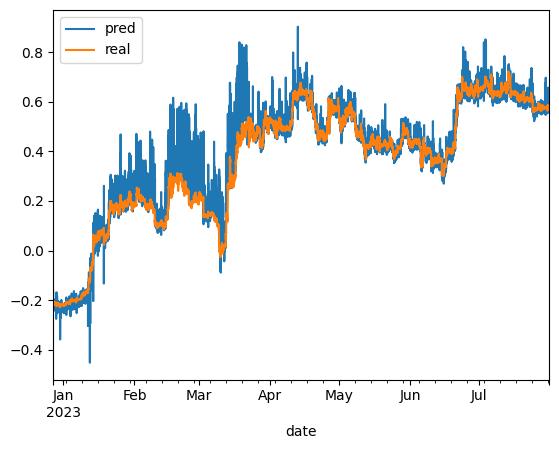

In [ ]:
df_results.plot()

In [ ]:
real_unscaled_values = get_inverse_target(
    scaler=scaler,
    var_obj="close",
    column_names=df_test.columns,
    values= df_results["real"]
)

pred_unescaled_values = get_inverse_target(
    scaler=scaler,
    var_obj="close",
    column_names=df_test.columns,
    values= df_results["pred"]
)

df_results_unscaled = pd.concat([real_unscaled_values.rename("real"), pred_unescaled_values.rename("pred")], axis=1)
df_results_unscaled

,real,pred
date,,
2022-12-27 15:00:00,16756.559900,17456.763910
2022-12-27 15:15:00,16782.690092,16388.802977
2022-12-27 15:30:00,16821.459911,16633.793510
2022-12-27 15:45:00,16814.339891,16950.982591
2022-12-27 16:00:00,16791.610098,16617.460106
...,...,...
2023-07-31 13:45:00,29421.520397,29565.137386
2023-07-31 14:00:00,29334.479740,29669.856292
2023-07-31 14:15:00,29350.959593,29356.758220


In [ ]:
mse = mean_squared_error(y_true=df_results_unscaled.real, y_pred=df_results_unscaled.pred)
mae = mean_absolute_error(y_true=df_results_unscaled.real, y_pred=df_results_unscaled.pred)

print(f"MSE -> {mse}")
print(f"MAE -> {mae}")

MSE -> 734560.1255478265
MAE -> 459.6584898037441


Hemos bajado los errores:

- MSE -> De 1809276.53 a 734560.12
- MAE -> De 1077.83 a 459.66

Lo que hemos hecho ha sido bajar el dropout y lo más importante hacer el modelo más simple (número de layers de 2 a 1). Esto ha permitido al modelo generalizar mejor.

Finalmente graficamos

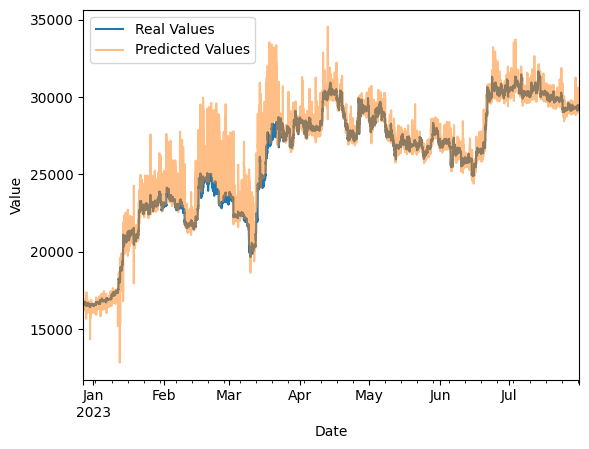

In [ ]:
import matplotlib.pyplot as plt

ax = df_results_unscaled['real'].plot(label='Real Values')
df_results_unscaled['pred'].plot(ax=ax, label='Predicted Values', alpha=0.5) #Hacemos más transparente para que se pueda ver el valor de la serie original

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()

## 8 - Próximos pasos

- Utilizar Transformers para Time Series para ver si conseguimos un mayor ajuste al obtenido con LSTMs.
- Aplicar transformaciones a los datos de GDELT como se hizo con las features del dataset de precios de bitcoin.
- Recolectar más datos sobre noticias que puedan afectar al predcio de otros medios